# 🤖 Logistic Regression

In this notebook, we implement and compare logistic regression models using:

- **Synthetic data** generated with Gaussian noise
- **SKLearn**'s built-in `LogisticRegression`
- **Manual gradient descent** optimization
- **Stochastic gradient descent (SGD)**
  
Evaluation metrics and visualizations are included for comparison.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## 🛠️ Utils

In [2]:
def sigmoid(z: NDArray[np.float64]) -> NDArray[np.float64]:
    """Compute the sigmoid activation function.

    Args:
        z (NDArray[np.float64]): Input array (can be a scalar, vector, or matrix).

    Returns:
        NDArray[np.float64]: Output after applying the sigmoid function element-wise.
    """
    return 1 / (1 + np.exp(-z))

---

In [3]:
def evaluate_regression(
    y_true: NDArray[np.float64], y_pred: NDArray[np.float64]
) -> dict[str, float]:
    """Compute and print regression evaluation metrics.

    Args:
        y_true (NDArray[np.float64]): True target values.
        y_pred (NDArray[np.float64]): Predicted target values.

    Returns:
        dict[str, float]: MAE, MSE, and R² score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{Fore.CYAN}Mean Absolute Error (MAE):{Style.RESET_ALL} {mae:.4f}")
    print(f"{Fore.CYAN}Mean Squared Error (MSE):{Style.RESET_ALL} {mse:.4f}")
    print(f"{Fore.CYAN}R² Score:{Style.RESET_ALL} {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}

In [4]:
def plot_regression_results(
    x: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
    y_pred: NDArray[np.float64],
    w: float,
    b: float,
    title: str = "Regression Plot",
) -> None:
    """Plot noisy data points, model predictions, and the original regression line.

    Args:
        x (NDArray[np.float64]): Full input features used to generate noisy data.
        y (NDArray[np.float64]): Noisy target values.
        X_test (NDArray[np.float64]): Test feature values used for predictions.
        y_pred (NDArray[np.float64]): Predicted values from the regression model.
        w (float): True slope of the underlying model (for reference line).
        b (float): True intercept of the underlying model.
        title (str): Title of the plot. Default is "Regression Plot".
    """
    x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_line = sigmoid(x_range * w + b)

    sns.scatterplot(x=x, y=y, alpha=0.3, label="True data")
    plt.scatter(X_test, y_pred, alpha=0.3, color="red", label="Model predictions")
    plt.plot(x_range, y_line, color="green", label="Ground truth line")
    plt.axhline(0.5, color="gray", linestyle="--", label="Decision boundary (0.5)")
    plt.title(title)
    plt.legend()
    plt.show()

## 📊 Generate Dataset

In [5]:
def generate_data(
    n: int, w: float, b: float, noise_level: float = 1.0, seed: int = 42
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Generate synthetic logistic data with Gaussian noise.

    Args:
        n (int): Number of data points to generate.
        w (float): Slope of the linear function.
        b (float): Intercept of the linear function.
        noise_level (float): Standard deviation of Gaussian noise added to the data.
        seed (int): Seed for the random number generator.

    Returns:
        tuple[NDArray[np.float64], NDArray[np.float64]]: Tuple containing the list of x
        values and corresponding noisy y values.
    """
    rng = np.random.default_rng(seed)
    x = rng.uniform(0, 10, n)
    logits = w * x + b + rng.normal(0, noise_level, n)
    probs = sigmoid(logits)
    y = (probs > 0.5).astype(int)
    return x, y


# Set true parameters of the linear relationship
w = 2.5  # Slope coefficient
b = -12.0  # Intercept (bias term)

# Generate dataset
x, y = generate_data(n=1000, w=w, b=b, noise_level=4.5)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Convert lists to numpy arrays with correct shape for sklearn
X_train_np = np.array(X_train).reshape(-1, 1)
X_test_np = np.array(X_test).reshape(-1, 1)

## ⚙️ SKLearn Model

In [7]:
# Create and train the model
model = LogisticRegression()
model.fit(X_train_np, y_train)

# Predict on test data
predicted = model.predict(X_test_np)

# Print model parameters
print(f"{Fore.BLUE}Model coefficients:{Style.RESET_ALL} {model.coef_}")
print(f"{Fore.MAGENTA}Intercept:{Style.RESET_ALL} {model.intercept_}")

Model coefficients: [[1.07004596]]
Intercept: [-5.26790362]


In [8]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 0.1550
Mean Squared Error (MSE): 0.1550
R² Score: 0.3709


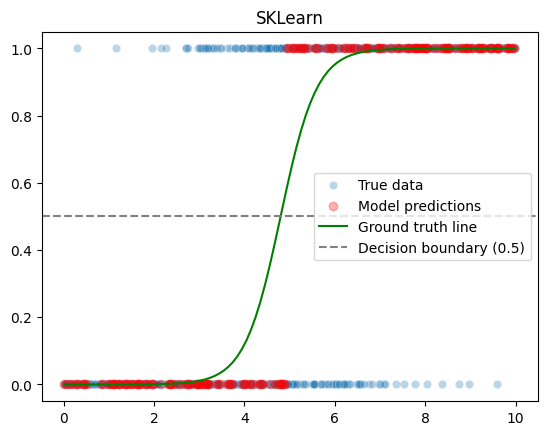

In [9]:
plot_regression_results(x, y, X_test, predicted, w, b, "SKLearn")

## 🧪 Custom Implementations

### 🔁 Gradient Descent (Batch GB)

In [10]:
# Initialize parameters
max_epochs = 1000000
alpha = 1e-4  # learning rate
tolerance = 1e-7

m, n_features = X_train_np.shape
w_pred = np.zeros(n_features)  # initial weight
b_pred = 0.0  # initial bias

prev_loss = float("inf")

for epoch in range(max_epochs):
    y_pred = sigmoid(X_train_np @ w_pred + b_pred)
    error = y_pred - y_train

    grad_w = (1 / m) * X_train_np.T @ error
    grad_b = (1 / m) * np.sum(error)

    # Gradient descent update rules
    w_pred -= alpha * grad_w
    b_pred -= alpha * grad_b

    loss = -np.mean(
        y_train * np.log(y_pred + 1e-8) + (1 - y_train) * np.log(1 - y_pred + 1e-8)
    )

    # Check for convergence
    if abs(prev_loss - loss) < tolerance:
        print(f"Converged at epoch {epoch}")
        break

    prev_loss = loss

# Predict on test data
probs = sigmoid(X_test_np @ w_pred + b_pred)
predicted = (probs > 0.5).astype(int)

# Print model parameters
print(f"{Fore.BLUE}Model coefficients:{Style.RESET_ALL} {w_pred}")
print(f"{Fore.MAGENTA}Intercept:{Style.RESET_ALL} {b_pred}")

Converged at epoch 445136
Model coefficients: [0.68343957]
Intercept: -3.133963390736726


In [11]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 0.1550
Mean Squared Error (MSE): 0.1550
R² Score: 0.3709


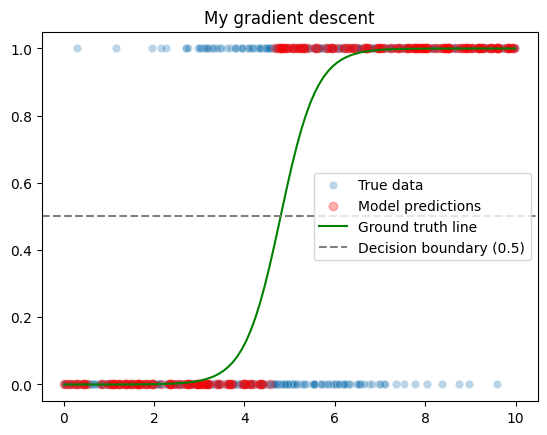

In [12]:
plot_regression_results(x, y, X_test, predicted, w, b, "My gradient descent")

### 🔄 Stochastic Gradient Descent (SGD)

In [13]:
# Initialize parameters
max_epochs = 1000000
alpha = 1e-4  # learning rate
tolerance = 1e-7
lambda_rate = 0.01

m, n_features = X_train_np.shape
w_pred = np.zeros(n_features)  # initial weight
b_pred = 0.0  # initial bias

prev_loss = float("inf")

for epoch in range(max_epochs):
    indices = np.random.permutation(m)
    X_train_shuffled = X_train_np[indices]
    y_train_shuffled = y_train[indices]

    for i in range(m):
        xi = X_train_shuffled[i]
        yi = y_train_shuffled[i]

        y_pred = sigmoid(xi @ w_pred + b_pred)
        error_i = y_pred - yi + w_pred**2 * lambda_rate  # L2 penalty

        grad_w = xi * error_i
        grad_b = error_i

        # Gradient descent update rules
        w_pred -= alpha * grad_w
        b_pred -= alpha * grad_b

    y_pred_all = sigmoid(X_train_np @ w_pred + b_pred)
    loss = -np.mean(
        y_train * np.log(y_pred_all + 1e-8)
        + (1 - y_train) * np.log(1 - y_pred_all + 1e-8)
    )

    # Check for convergence
    if abs(prev_loss - loss) < tolerance:
        print(f"Converged at epoch {epoch}")
        break

    prev_loss = loss

# Predict on test data
probs = sigmoid(X_test_np @ w_pred + b_pred)
predicted = (probs > 0.5).astype(int)

# Print model parameters
print(f"{Fore.BLUE}Model coefficients:{Style.RESET_ALL} {w_pred}")
print(f"{Fore.MAGENTA}Intercept:{Style.RESET_ALL} {b_pred}")

Converged at epoch 1016
Model coefficients: [0.82310387]
Intercept: [-3.97113712]


In [14]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 0.1550
Mean Squared Error (MSE): 0.1550
R² Score: 0.3709


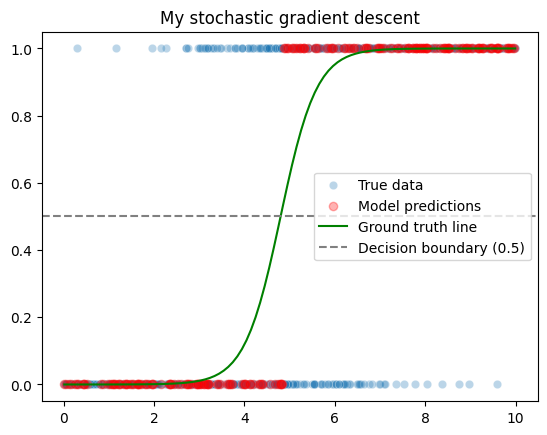

In [15]:
plot_regression_results(x, y, X_test, predicted, w, b, "My stochastic gradient descent")